## Team:
    
Sanket Talaviya

## Summary

We have used fastai and transformers to solve this problem.

The fastai library simplifies training fast and accurate neural nets using modern best practices. 
The library is based on research into deep learning best practices undertaken at fast.ai, and includes "out of the box" support for vision, text, tabular, and collab (collaborative filtering) models.

## Training methodology:

Now we can finally use all the fastai build-in features to train our model. we will use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and **gradually unfreeze the model**.

## Notable aspects

Using pretrained RoBERTa model from transformer package.

## References
1. https://docs.fast.ai/callbacks.one_cycle.html
2. https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2

## Note:
    Please note Data isnt uploaded here. So you need to create data folder and put train.csv and test.csv files in that.

In [1]:
!pip install -q fastai
!pip install -q transformers

In [2]:
import numpy as np
import pandas as pd 
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

In [3]:
train = pd.read_csv( './data/train.csv')
test = pd.read_csv('./data/test.csv')
print(train.shape,test.shape)
train.head()

(1900, 2) (211, 2)


,label,text
0,Negative,No one cares about marketing slides - a techni...
1,Positive,Are all three hosts providing storage/capacity...
2,Negative,would loved to had managed to get down to the ...
3,Negative,Vending machine at work is out of Dasani water...
4,Positive,"RT @VMwareEdu: Paul Maritz, CEO and President ..."


In [4]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

In [5]:
model_class, tokenizer_class, config_class = (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig)

Print the available values for ``pretrained_model_name`` (shortcut names) corresponding to the ``model_type`` used.

Function to set the seed for generating random numbers.

In [6]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars

In [7]:
seed_all(seed)

In [8]:
## We can simply create a new class TransformersBaseTokenizer that inherits from BaseTokenizer and overwrite a new tokenizer function.

class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        tokens = [CLS] + tokens + [SEP]
        return tokens

In [9]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [10]:
## It is worth noting that we don't add padding in this part of the implementation. As we will see later, fastai manage it automatically during the creation of the DataBunch.
## In fastai, NumericalizeProcessor object takes as vocab argument a Vocab object. From this analyse, there are two ways to adapt the fastai numericalizer:

# 1)  retreive the list of tokens and create a Vocab object.
# 2) Create a new class TransformersVocab that inherits from Vocab and overwrite numericalize and textify functions.

## We will go ahead with #2 option.

class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [11]:
## Notice we are passing the include_bos = False and include_eos = False options. 
## This is because fastai adds its own special tokens by default which interferes with the [CLS] and [SEP] tokens added by our custom tokenizer

transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [12]:
## Setting up the Databunch
## For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor ``transformer_processor`` and manage correctly the padding.
## As mentioned in the HuggingFace documentation, BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. 

pad_first = False
pad_idx = transformer_tokenizer.pad_token_id

In [13]:
tokens = transformer_tokenizer.tokenize('Nice to see VMware competition on Machine Learning')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['Nice', 'Ġto', 'Ġsee', 'ĠVMware', 'Ġcompetition', 'Ġon', 'ĠMachine', 'ĠLearning']
[41541, 7, 192, 32237, 1465, 15, 14969, 13807]


['Nice',
 'Ġto',
 'Ġsee',
 'ĠVMware',
 'Ġcompetition',
 'Ġon',
 'ĠMachine',
 'ĠLearning']

There is multible ways to create a DataBunch, in our implementation, we use [the data block API](https://docs.fast.ai/data_block.html#The-data-block-API), which gives more flexibility.

In [14]:
databunch = (TextList.from_df(train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

Check batch and tokenizer :

In [15]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
"<s> ĠUpdate . ĠThere Ġreally Ġis Ġa Ġnetwork Ġissue . ĠI Ġhadn 't Ġcaught Ġit Ġbecause Ġit 's Ġasymm etrical . ĠNow Ġto Ġfigure Ġout Ġhow Ġto Ġfix Ġit . ĠIt Ġapplies Ġto Ġboth Ġports Ġon Ġthe ĠNIC Ġon Ġthe Ġserver . ĠDoing Ġsome Ġfinal Ġtroubles hooting Ġto Ġseparate Ġbetween ĠNIC Ġissue Ġand ĠSwitch Ġissue , Ġbut Ġman ... Ġthis Ġthing Ġhurt Ġme Ġfor Ġa Ġl oooo ong Ġwhile .",Negative
"<s> ĠWell ĠI Ġnoticed Ġa Ġconfiguration Ġerror ĠI Ġmade Ġwhen ĠI Ġoriginally Ġcame Ġup Ġwith Ġa Ġbudget Ġfor Ġthis Ġproject Ġ( too Ġmany Ġcapacity Ġs sd 's ). ĠWell Ġthey Ġapproved Ġit Ġat Ġthe Ġprice Ġit Ġwas Ġand Ġwhen ĠI Ġcorrected Ġmy Ġerror Ġand Ġswapped Ġthe ĠS 37 00 's Ġto Ġthe ĠP 37 00 Ġit Ġactually Ġended Ġup Ġcheaper , Ġso Ġwe Ġare Ġgoing Ġto Ġgo Ġwith Ġthat .",Positive
<s> ĠThere Ġis Ġa Ġslightly Ġdifferent Ġmethod Ġfrom Ġsnapshots Ġyou Ġcan Ġuse Ġthat Ġmay Ġbe Ġthe Ġsolution Ġyou Ġare Ġlooking Ġfor . Ġ Ġ ĠCreate Ġyour Ġperfect Ġstarting ĠVM Ġthen Ġshut Ġit Ġdown Ġand Ġmake Ġthe Ġdisk Ġnon - pers istent . ĠDownload Ġthe Ġv mx Ġfile Ġand Ġuse Ġit Ġas Ġa Ġtemplate Ġto Ġmake Ġother Ġcl oned ĠV Ms . Ġ ĠYou Ġcan Ġupload Ġas Ġmany ĠV Ms Ġas,Positive
"<s> ĠAlright , Ġso Ġthis Ġis Ġgoing Ġto Ġbe Ġa Ġlittle Ġfunky Ġhere , Ġand Ġthere Ġis Ġa Ġvery Ġgood Ġchance Ġof Ġfucking Ġeverything Ġup ... Ġ ĠIf Ġyou Ġhave Ġany Ġspace Ġavailable , Ġuse Ġsomething Ġlike Ġg part d Ġand Ġcreate Ġtwo Ġpartitions . Ġ ĠMake Ġone Ġa Ġfew Ġgigs Ġin Ġsize Ġand Ġgive Ġthe Ġother Ġpartition Ġthe Ġrest Ġof Ġthe Ġspace . Ġ ĠThen Ġinstall ĠES Xi Ġon",Positive
"<s> ĠSo oo ĠJust Ġa Ġheads Ġup Ġ, ĠI Ġpush ĠVideo Ġediting Ġwork st ations Ġfrom ĠNYC Ġto ĠCal cut ta ĠIndia Ġand ĠMo Bay ĠJamaica Ġ. Ġ Ġ Ġ ĠPC O IP ĠIs Ġhow ĠI Ġdo Ġit Ġ. Ġ Ġ ĠI Ġhad Ġto Ġcustomize Ġthe ĠPC O IP Ġ( band width Ġfloor , Ġ Ġframe Ġrate , Ġau ido Ġquality .. ) Ġsettings Ġfor Ġeverything , Ġ Ġ ĠI",Positive


Check batch and numericalizer :

In [16]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([16, 512])
tensor([[    0,   598, 17678,  ..., 10393,  2577,     2],
        [    0,   345,    16,  ...,     1,     1,     1],
        [    0, 41881,     6,  ...,     1,     1,     1],
        ...,
        [    0,    38,    33,  ...,     1,     1,     1],
        [    0,   440,   464,  ...,     1,     1,     1],
        [    0,    38,   206,  ...,     1,     1,     1]])


In [17]:
### Custom model
## As mentioned [here](https://github.com/huggingface/transformers#models-always-output-tuples), every model's forward method always outputs a ``tuple`` with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits. 
## One way to access them is to create a custom model.
                    
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [18]:
## set configs

config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}



In [19]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [20]:
# In pytorch-transformers, HuggingFace had implemented two specific optimizers  -  BertAdam and OpenAIAdam  -  that have been replaced by a single AdamW optimizer. 
# This optimizer matches Pytorch Adam optimizer Api, therefore, it becomes straightforward to integrate it within fastai. It is worth noting that for reproducing BertAdam specific behavior, you have to set correct_bias = False.

from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [21]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i

We can decide to divide the model in 14 blocks :
* 1 Embedding
* 12 transformer
* 1 classifier

In this case, we can split our model in this way :

In [22]:
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]



Check groups : 

In [23]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)


Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2)

## Train
Now we can finally use all the fastai build-in features to train our model. we will use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and **gradually unfreeze the model**.

In [24]:
learner.save('untrain')

In [25]:
seed_all(seed)
learner.load('untrain');

Therefore, we first freeze all the groups but the classifier with :

In [26]:
learner.freeze_to(-1)

We check which layer are trainable.

In [27]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 768]           38,603,520 False     
______________________________________________________________________
Embedding            [512, 768]           394,752    False     
______________________________________________________________________
Embedding            [512, 768]           768        False     
______________________________________________________________________
LayerNorm            [512, 768]           1,536      False     
______________________________________________________________________
Dropout              [512, 768]           0          False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
_______________________________________

For **Slanted Triangular Learning Rates** you have to use the function ``one_cycle``. For more information please check the fastai documentation [here](https://docs.fast.ai/callbacks.one_cycle.html). 

To use our ``one_cycle`` we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using ``lr_find``.

In [28]:
learner.lr_find()

epoch     train_loss  valid_loss  accuracy  error_rate  time    
0         6.364385    #na#        01:18     
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


/usr/local/lib/python3.7/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


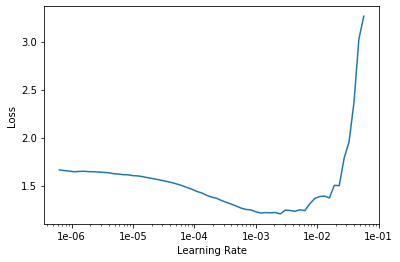

In [29]:
learner.recorder.plot(skip_end=5)

We will pick a value around the minimum. Here 2x10^-3 seems to be a good value.

Next we will use ``fit_one_cycle`` with the chosen learning rate as the maximum learning rate. 

In [30]:
learner.fit_one_cycle(1,max_lr=2e-3,moms=(0.8,0.7))

epoch     train_loss  valid_loss  accuracy  error_rate  time    
0         0.654980    0.505112    0.784211  0.215789    02:01     


In [31]:
learner.save('first_cycle')

In [32]:
seed_all(seed)
learner.load('first_cycle');

We then unfreeze the second group of layers and repeat the operations.

In [33]:
learner.freeze_to(-2)

In [34]:
lr = 1e-5

Note here that we use slice to create separate learning rate for each group.

In [35]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch     train_loss  valid_loss  accuracy  error_rate  time    
0         0.482140    0.408488    0.842105  0.157895    02:09     


In [36]:
learner.save('second_cycle')

In [37]:
seed_all(seed)
learner.load('second_cycle');

In [38]:
learner.freeze_to(-3)

In [39]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch     train_loss  valid_loss  accuracy  error_rate  time    
0         0.355942    0.294719    0.863158  0.136842    02:31     


In [40]:
learner.save('third_cycle')

In [41]:
seed_all(seed)
learner.load('third_cycle');

Here, we unfreeze all the groups.

In [42]:
learner.unfreeze()

In [43]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch     train_loss  valid_loss  accuracy  error_rate  time    
0         0.345208    0.247719    0.884211  0.115789    06:36     
1         0.183688    0.248775    0.894737  0.105263    06:33     


Now, you can predict examples with:

In [44]:
learner.predict('This is the best movie of 2020')

(Category tensor(1),
 tensor(1),
 tensor([1.8102e-01, 8.1896e-01, 8.9981e-06, 1.1919e-05, 8.0093e-06]))

In [45]:
learner.predict('This is the worst movie of 2020')

(Category tensor(0),
 tensor(0),
 tensor([9.9691e-01, 3.0437e-03, 1.4607e-05, 1.7345e-05, 1.5531e-05]))

## Export Learner
In order to export and load the learner you can do these operations:

In [46]:
learner.export(file = 'transformer.pkl');

In [47]:
path = '.'
export_learner = load_learner(path, file = 'transformer.pkl')

As mentioned [here](https://docs.fast.ai/basic_train.html#load_learner), you have to be careful that each custom classes - like ``TransformersVocab`` - are first defined before executing ``load_learner``.

In [48]:
export_learner.predict('This is the worst movie of 2020')

(Category tensor(0),
 tensor(0),
 tensor([9.9691e-01, 3.0437e-03, 1.4607e-05, 1.7345e-05, 1.5531e-05]))

## Creating prediction
Now that the model is trained, we want to generate predictions from the test dataset.

In [49]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [50]:
sample_submission = pd.read_csv('./data/test.csv')
sample_submission['Sentiment'] = np.argmax(test_preds,axis=1)
sample_submission['Sentiment'] = sample_submission['Sentiment'].apply(lambda x: 'Positive' if x == 1 else 'Negative')

sample_submission = sample_submission.rename(columns={'Sentiment': 'label'})
sample_submission.drop(columns=['text'], inplace=True)

sample_submission.to_csv("predictions1.csv", index=False)

In [51]:
test = pd.read_csv('predictions1.csv')
test

,id,label
0,0,Positive
1,1,Positive
2,2,Positive
3,3,Positive
4,4,Negative
...,...,...
206,206,Positive
207,207,Positive
208,208,Positive
209,209,Negative


In [52]:
test.label.value_counts()

Positive    119
Negative     92
Name: label, dtype: int64